# Comparing SOSE and WOA datasets
for model validation

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
woa_8110 = xr.open_dataarray('/home/jovyan/WMT/WOA/ts_hist_8110.nc')
woa_0517 = xr.open_dataarray('/home/jovyan/WMT/WOA/ts_hist_0517.nc')
sose = xr.open_dataarray('/home/jovyan/WMT/SOSE-budgets/ts_hist_mean_SOSE.nc')

## Difference between SOSE and WOA (1981-2010)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


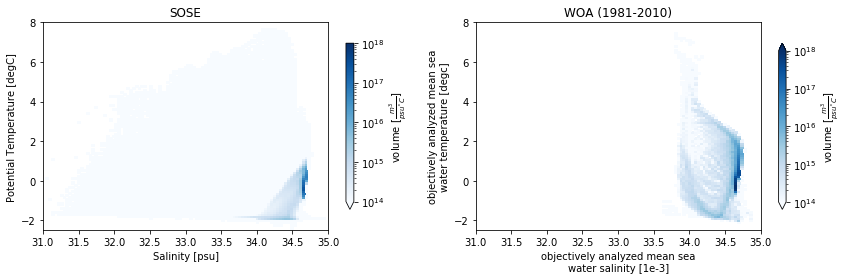

In [3]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

sose.where(sose>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('SOSE')

woa_8110.where(woa_8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (1981-2010)')

plt.tight_layout();

In [4]:
sose

<xarray.DataArray 'histogram_THETA_SALT' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [5]:
woa_8110

<xarray.DataArray 'histogram_theta_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [6]:
diff_sose_woa8110 = sose - woa_8110
diff_sose_woa8110

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

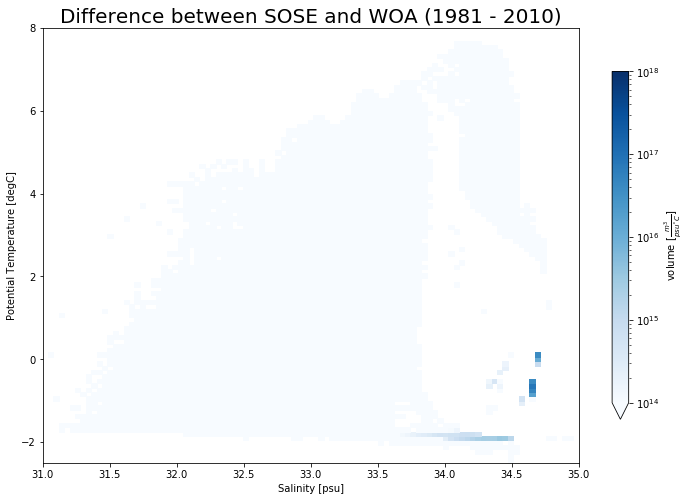

In [21]:
diff_sose_woa8110.where(diff_sose_woa8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18, figsize=(12,8),
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
plt.title('Difference between SOSE and WOA (1981 - 2010)', fontsize=20);

## Difference between SOSE and WOA (2005-2017)

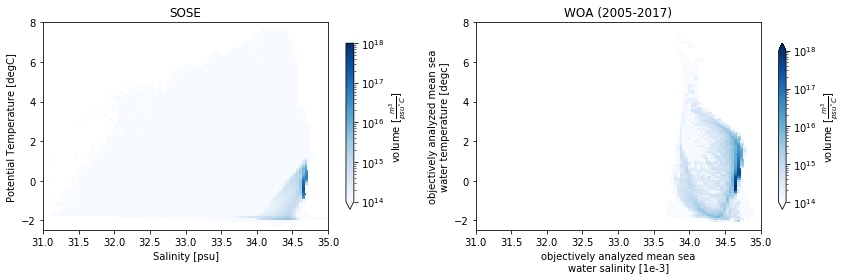

In [10]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

sose.where(sose>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('SOSE')

woa_0517.where(woa_0517>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (2005-2017)')

plt.tight_layout();

In [11]:
woa_0517

<xarray.DataArray 'histogram_theta_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [12]:
diff_sose_woa0517 = sose - woa_0517
diff_sose_woa0517

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

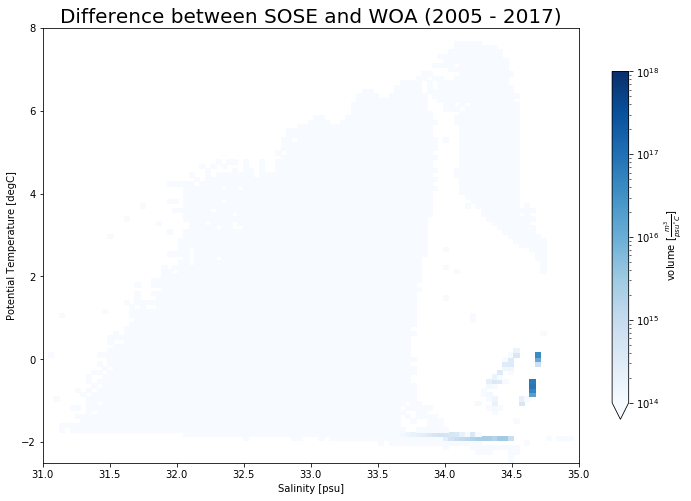

In [22]:
diff_sose_woa0517.where(diff_sose_woa0517>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e14, vmax=1e18, figsize=(12,8),
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
plt.title('Difference between SOSE and WOA (2005 - 2017)', fontsize=20);